In [64]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import matplotlib as mpl

In [65]:
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [66]:
# 网格世界环境
class GridWorld:
    def __init__(self, agent_position=(0, 0), goal_position=(4, 4), width=5, height=5):
        self.width = width
        self.height = height
        self.agent_position = agent_position  # 初始位置：左上角
        self.goal_position = goal_position  # 目标位置：右下角
        self.obstacles = [(1, 1), (2, 2), (3, 1)]  # 障碍物位置
        
        # 定义动作 (上, 右, 下, 左)
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.action_names = ["上", "右", "下", "左"]
        
    def reset(self):
        self.agent_position = (0, 0)
        return self.agent_position
    
    def is_valid_position(self, position):
        x, y = position
        return (0 <= x < self.width and 
                0 <= y < self.height and 
                position not in self.obstacles)
    
    def step(self, action_idx):
        action = self.actions[action_idx]
        
        # 计算新位置
        new_position = (self.agent_position[0] + action[0], 
                        self.agent_position[1] + action[1])
        
        # 检查是否是有效位置
        if self.is_valid_position(new_position):
            self.agent_position = new_position
            
        # 计算奖励和是否终止
        if self.agent_position == self.goal_position:
            reward = 100  # 达到目标的奖励
            done = True
        else:
            reward = -1  # 每一步的惩罚，鼓励找到最短路径
            done = False
            
        return self.agent_position, reward, done
    
    def render(self, q_table=None):
        grid = [['□' for _ in range(self.width)] for _ in range(self.height)]
        
        # 放置障碍物
        for obs in self.obstacles:
            grid[obs[0]][obs[1]] = '■'
        
        # 放置目标
        grid[self.goal_position[0]][self.goal_position[1]] = '★'
        
        # 放置智能体
        grid[self.agent_position[0]][self.agent_position[1]] = '○'
        
        # 可视化Q值（可选）
        if q_table is not None:
            print("The Q(s,a) of the position: ")
            state = self.agent_position
            for i, action_name in enumerate(self.action_names):
                print(f"{action_name}: {q_table[state[0], state[1], i]:.2f}", end=", ")
            print()
                
        # 打印网格
        for row in grid:
            print(' '.join(row))
        print()


In [ ]:
# SARSA simple implement
class SARSA:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha      # 学习率
        self.gamma = gamma      # 折扣因子
        self.epsilon = epsilon  # 探索率
        
        # 初始化Q表 - 状态为(x, y)，动作为0-3
        self.q_table = np.zeros((env.width, env.height, len(env.actions)))
        
    def choose_action(self, state):
        # 使用ε-greedy策略选择动作
        if random.random() < self.epsilon:
            # 四个action中随机选择一个作为下一个action，展示exploration的思路
            return random.randint(0, len(self.env.actions) - 1)  # 探索：随机选择
        else:
            # state[0], state[1]代表了当前的状态，用该状态去Q表中检索
            return np.argmax(self.q_table[state[0], state[1]])   # 利用：选择最大Q值
    
    def train(self, episodes=1000):
        rewards_history = []
        steps_history = []
        
        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            steps = 0
            done = False
            
            while not done:
                # 执行动作，观察下一个状态和奖励
                next_state, reward, done = self.env.step(action)
                total_reward += reward
                steps += 1
                
                # 选择下一个动作
                next_action = self.choose_action(next_state)
                
                # SARSA更新
                current_q = self.q_table[state[0], state[1], action]
                next_q = self.q_table[next_state[0], next_state[1], next_action]
                
                # Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
                self.q_table[state[0], state[1], action] = \
                    current_q + self.alpha * (reward + self.gamma * next_q - current_q)
                
                # 更新状态和动作
                state = next_state
                action = next_action
            
            rewards_history.append(total_reward)
            steps_history.append(steps)
            
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode + 1}/{episodes}, Average Reward: {np.mean(rewards_history[-100:]):.2f}, Average Steps: {np.mean(steps_history[-100:]):.2f}")
                
        return rewards_history, steps_history
    
    def evaluate(self, render=True):
        state = self.env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        if render:
            print("Evaluate mode - show policy learned:")
            self.env.render(self.q_table)
            time.sleep(1)
        
        while not done:
            # 选择最优动作（不再探索）
            action = np.argmax(self.q_table[state[0], state[1]])
            
            # 执行动作
            next_state, reward, done = self.env.step(action)
            total_reward += reward
            steps += 1
            state = next_state
            
            if render:
                self.env.render(self.q_table)
                time.sleep(1)
                
        if render:
            print(f"Evaluate finished - total reward: {total_reward}, total steps: {steps}")
        
        return total_reward, steps


In [ ]:
# 可视化学习进度
def plot_learning(rewards, steps):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('reward per episode')
    plt.xlabel('episode number')
    plt.ylabel('cumulative reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(steps)
    plt.title('steps per episode')
    plt.xlabel('episode number')
    plt.ylabel('step number')
    
    plt.tight_layout()
    plt.show()


开始训练...
Episode 10/100, Average Reward: -2.00, Average Steps: 103.00
Episode 20/100, Average Reward: 3.45, Average Steps: 97.55
Episode 30/100, Average Reward: 15.30, Average Steps: 85.70
Episode 40/100, Average Reward: 23.25, Average Steps: 77.75
Episode 50/100, Average Reward: 27.12, Average Steps: 73.88
Episode 60/100, Average Reward: 28.50, Average Steps: 72.50
Episode 70/100, Average Reward: 33.84, Average Steps: 67.16
Episode 80/100, Average Reward: 35.84, Average Steps: 65.16
Episode 90/100, Average Reward: 35.09, Average Steps: 65.91
Episode 100/100, Average Reward: 35.51, Average Steps: 65.49


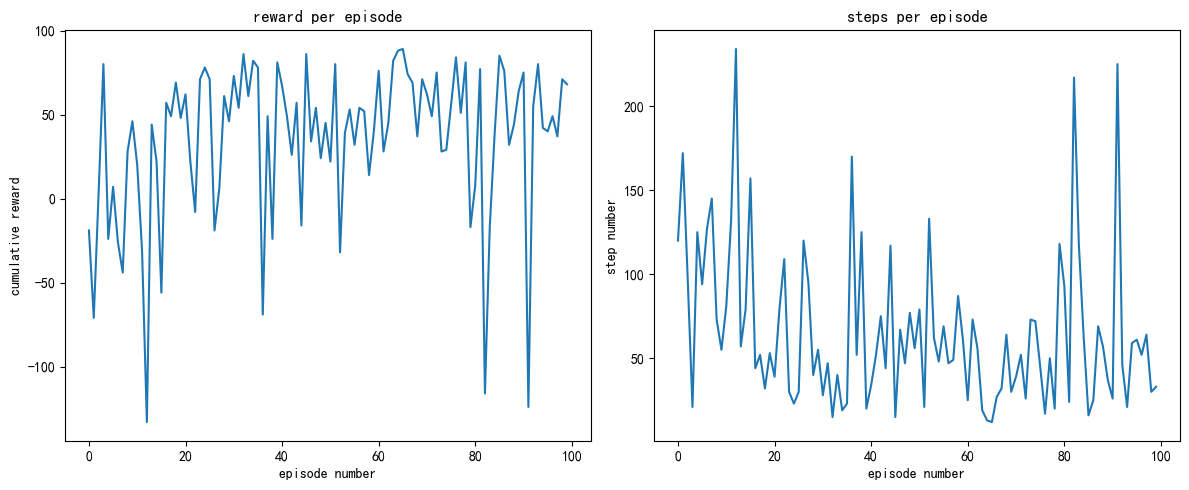

Evaluate mode - show policy learned:
The Q(s,a) of the position: 
上: -11.05, 右: -9.79, 下: -10.49, 左: -10.69, 
○ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -9.88, 右: -6.13, 下: -9.68, 左: -11.03, 
□ ○ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -7.03, 右: -1.78, 下: -3.36, 左: -9.32, 
□ □ ○ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -3.06, 右: -1.51, 下: 2.07, 左: -6.07, 
□ □ □ ○ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -4.22, 右: 5.21, 下: 9.14, 左: -3.66, 
□ □ □ □ □
□ ■ □ ○ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -2.37, 右: 16.81, 下: 23.09, 左: 5.58, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ ○ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: 9.69, 右: 53.48, 下: 26.89, 左: 16.94, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ ○ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: 18.81, 右: 27.53, 下: 99.82, 左: 20.94, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ ○
□ □ □ □

In [ ]:
# 主函数
def main():
    # 创建环境和智能体
    env = GridWorld(width=5, height=5)
    sarsa_agent = SARSA(env, alpha=0.1, gamma=0.9, epsilon=0.1)
    
    # 训练
    print("开始训练...")
    rewards, steps = sarsa_agent.train(episodes=100)
    
    # 绘制学习曲线
    plot_learning(rewards, steps)
    
    # 评估
    sarsa_agent.evaluate(render=True)
    
    # 显示学习到的策略
    print("\n学习到的策略 (最优动作):")
    for i in range(env.width):
        for j in range(env.height):
            if (i, j) in env.obstacles:
                print("■", end="\t")
            elif (i, j) == env.goal_position:
                print("★", end="\t")
            else:
                best_action = np.argmax(sarsa_agent.q_table[i, j])
                print(env.action_names[best_action], end="\t")
        print()

if __name__ == "__main__":
    main()

```text
○ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

这是初始状态。人类可以一眼看出第一步走右边或者下面其实是没有区别的，但是由于阻挡物的存在，在计算Q的时候，势必会对先向下再向右的策略产生影响。
当epsilon较小的时候，策略倾向于绝对的直接向右，而不是向下。

调整额epsilon 让策略能够更加地开放，终于当epsilon可以达到0.6的时候，终于可以探索出来初始状态直接向下也是可行的。

Evaluate mode - show policy learned:
The Q(s,a) of the position: 
上: -4.34, 右: -3.96, 下: -3.91, 左: -4.31, 
○ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -3.86, 右: -3.48, 下: -2.70, 左: -3.61, 
□ □ □ □ □
○ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -3.34, 右: -3.34, 下: -0.78, 左: -3.32, 
□ □ □ □ □
□ ■ □ □ □
○ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -2.88, 右: -1.46, 下: 2.67, 左: -1.05, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
○ ■ □ □ □
□ □ □ □ ★

The Q(s,a) of the position: 
上: -1.28, 右: 15.17, 下: 1.21, 左: 1.46, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
○ □ □ □ ★

The Q(s,a) of the position: 
上: 1.45, 右: 24.27, 下: 7.48, 左: 1.49, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ ○ □ □ ★

The Q(s,a) of the position: 
上: 5.30, 右: 62.61, 下: 22.09, 左: 6.43, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ ○ □ ★

The Q(s,a) of the position: 
上: 7.23, 右: 98.80, 下: 41.26, 左: 9.62, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ ○ ★

The Q(s,a) of the position: 
上: 0.00, 右: 0.00, 下: 0.00, 左: 0.00, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ○

Evaluate finished - total reward: 93, total steps: 8

学习到的策略 (最优动作):
下	右	右	下	下	
下	■	右	右	下	
下	左	■	下	下	
下	■	右	右	下	
右	右	右	右	★
```